![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

#### Análisis Descriptivo "Workingday"

Al abrir por la variable Workingday, se puede observar que en promedio, se utilizan más biciletas un día laboral (workingday = 1) que un día no laboral.
Esto es esperable dado que en días laborales, las personas tienen le necesidad de movilizarce para ir desde sus hogares a sus trabajos o sus centros de estudio, mientras que en los días no laborales, movilizarse no es una obligación sino que esto pasa a ser opcional.

Adicionalmente como se puede ver en la parte inferior, al obtener otras medidas de la variable total, diferenciandola por el estado de workingday, se puede ver que por un lado hay muhcos mas datos de workingday = 1 (7,412) vs. workingday = 0 (3,474). Y EN LOS WORKINGDAY = 1 se obtuvo un máximo de 977 alquires mientras que un un dia no laboral, el máximo fue solo de 783. 


In [12]:
bikes_workingday_1= bikes[bikes["workingday"] == 1] 
bikes_workingday_1.total.describe()

count    7412.000000
mean      193.011873
std       184.513659
min         1.000000
25%        41.000000
50%       151.000000
75%       277.000000
max       977.000000
Name: total, dtype: float64

In [14]:
bikes_workingday_0= bikes[bikes["workingday"] == 0] 
bikes_workingday_0.total.describe()

count    3474.000000
mean      188.506621
std       173.724015
min         1.000000
25%        44.000000
50%       128.000000
75%       304.000000
max       783.000000
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [75]:
bikes.groupby('hour').total.max()

hour
0     283
1     168
2     119
3      66
4      28
5      57
6     213
7     596
8     839
9     414
10    539
11    647
12    757
13    729
14    730
15    724
16    783
17    970
18    977
19    743
20    551
21    584
22    502
23    256
Name: total, dtype: int64

#### Análisis Descriptivo "hour"

Viendo la variable hora, podemos ver que esta tiene el pico del promedio de alquieleres a las 5-6 de la tarde. Por el contrario, en la mañana, que uno también esperaría un pico sobresaliente dado que es el momento que los usuarios tiene que movilizarce usualmente sus lugares de educativos o laborales no hay un pico marcado, este se distrbuye mucho más homogeneo desde las 7am hasta las 10 am que ya empieza a bajar.
Así mismo se puede ver reflejado que en el horario nocturno, el promedio de alquileres baja drásticamente.

Viendo la hora donde se obtuvo el máximo de alquires de bicicletas, este también ocurrió a las 5 y 6 de la tarde donde se obtuvieron unos totales de 970 y 977 respectivamente.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

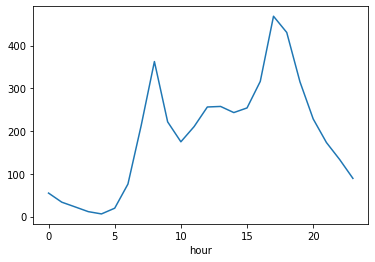

In [78]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

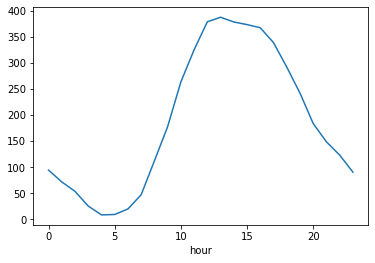

In [76]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes_workingday_0.groupby('hour').total.mean().plot()

Analisis 2.2
Cuando solo tenemos los totales de alquiler en los dias no laborales, wooingday = 0, se puede ver que el uso de las bicicletas en la mañana es bajo y en la mitad del dia muy alto. Esto se explica por el hecho de que el uso de bicicletas en estos días probablemente no está concentrado en poblacion que se levanta temprano a ir a sus lugares de trabajo. Por el contrario está para la gente que quizas quiere hacer un deporte o tener eventos sociales que usualmente son más tarde.

<AxesSubplot:xlabel='hour'>

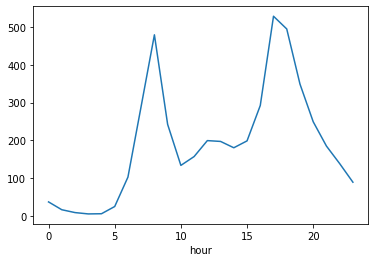

In [77]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes_workingday_1.groupby('hour').total.mean().plot()

Analisis 2.2 Cuando solo tenemos los totales de alquiler en los dias laborales, se tiene dos picos muy marcados que son cuando usualemente es la entra y salida de la jornada laboral. Estos son a las 8 y a las 5-6 de la tarde. Por el contrario se tiene un horario valle donde el probmedio de utlizaciones de solo 200 biciletas , que tiene un leve pico al medio dia, es decir a la hora del almuerzo. 

Teniendo en cuenta que la gráfica general tiene un promedio mucho más parecido a esta gráfica se podría deducir si no se supiera el total de los datos, que seguramente hay muchos mas datos de jornada laboral, pues la figura general tiene practicamente la misma forma que la de solo los datos de este tipo

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [38]:
# Celda 3
reg_y = bikes.total
reg_x = bikes[['hour', 'workingday']]
model = LinearRegression()
model.fit(reg_x, reg_y)
#print('intercept:', model.intercept_)
#print('slope:', model.coef_)

import statsmodels.api as sm
from scipy import stats
X2 = sm.add_constant(reg_x)
est = sm.OLS(reg_y, X2).fit()
print(est.summary())



                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     1041.
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:08:59   Log-Likelihood:                -71093.
No. Observations:               10886   AIC:                         1.422e+05
Df Residuals:                   10883   BIC:                         1.422e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.7060      3.866     17.514      0.0

La limitación de la regresión lineal es que se tiene que cumplir todos los supuesto de un modelo de regresión lineal para que el resultado sea confiable. Estos de hecho no se está cumpliendo como se puede apreciar en el cuadro anterior. Así mismo, en este modelo vemos que workinghour nisiquiera está saliendo significativa, por lo cual el modelo en realidad terminaría siendo solo de la hora del día.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [30]:
# Celda 4

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

n = tree_grow(reg_x,reg_y)
n

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 7207.700659959655,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 646.8008927589567,
   'sl': {'y_pred': 1,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': [0, 2.0],
    'n_samples': 2684,
    'gain': 382.8088308604629,
    'sl': {'y_pred': 1,
     'y_prob': 44.41383095499451,
     'level': 4,
     'split': [1, 1.0],
     'n_samples': 909,
     'gain': 1402.5704281636313,
     'sl': {'y_pred': 1,
      'y_prob': 82.63356164383562,
      'level': 5,
      'split': [0, 1.0],
      'n_samples': 290,
      'gain': 254.91262782401645,
      'sl': {'y_pred': 1,
       'y_prob': 93.21088435374149,
       'level': 6,
       'split': -1,
       'n_samples': 145,


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [40]:
# Celda 5
from sklearn import metrics

clf = DecisionTreeRegressor( random_state=1)
clf.fit(reg_x, reg_y)


#Prediction using test set 
y_pred = clf.predict(reg_x)
mae=metrics.mean_absolute_error(reg_y, y_pred)
mse=metrics.mean_squared_error(reg_y, y_pred)
# Printing the metrics

print("MODELO ARBOLES DE DECISION")
print('R2 square:',metrics.r2_score(reg_y, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print("")


#Prediction using test set 
y_pred = model.predict(reg_x)
mae=metrics.mean_absolute_error(reg_y, y_pred)
mse=metrics.mean_squared_error(reg_y, y_pred)
# Printing the metrics
print("MODELO REGRESION LINEAL")
print('R2 square:',metrics.r2_score(reg_y, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)


MODELO ARBOLES DE DECISION
R2 square: 0.6547025809438785
MAE:  70.75790612519393
MSE:  11329.31152387664

MODELO REGRESION LINEAL
R2 square: 0.16059115011434855
MAE:  125.18715914508772
MSE:  27541.255252498402


Arriba podemos ver los resultados en 3 métricas diferentes obtenidas con el modelo de Regresion Lineal y el modelo de Arboles. Se puede ver que consistemente el modelo de árboles está arrojando mejores métricas que la regresión lineal, por ejemplo en el R2 está logrando 65% vs. solo un 16%.

Por ende si se tuviera que escoger un modelo, sin lugar a dudas el elegido sería el arbol de decisíon.


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [41]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [44]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [47]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [51]:
# Celda 6

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []
f1_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    f1_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='f1').mean())

    

Text(0, 0.5, 'f1_scores and accuracy')

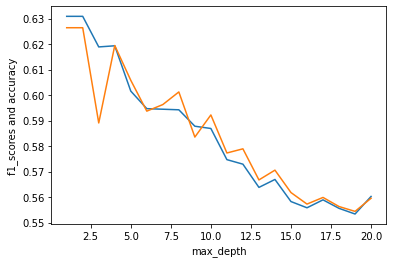

In [54]:
# Gráfica del salario, años y hits
%matplotlib inline
import matplotlib.pyplot as plt

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
#plt.ylabel('Accuracy')


# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, f1_scores)
plt.xlabel('max_depth')
plt.ylabel('f1_scores and accuracy')

Acá se puede apreciar que el max_depth optimo está siendo 2, pues posterior a este depth, el modelo empieza a caer en score F1 y en accuracci practiamente de manera lineal.

In [63]:
from sklearn.linear_model import LogisticRegression

#logit_model=sm.Logit(y_train,X_train)
#result=logit_model.fit()
#print(result.summary2())

# Celda 3
model_log = LogisticRegression()
model_log.fit(X_train, y_train)
#print('intercept:', model.intercept_)
#print('slope:', model.coef_)


# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores_logit = []
f1_scores_logit = []

accuracy_scores_logit.append(cross_val_score(model_log, X_train, y_train, cv=10, scoring='accuracy').mean())
f1_scores_logit.append(cross_val_score(model_log, X_train, y_train, cv=10, scoring='f1').mean())

print("ACCURACY:", accuracy_scores_logit)
print("F1_SCORE", f1_scores_logit)



ACCURACY: [0.612]
F1_SCORE [0.6017557626948106]


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [73]:
# 100 árboles de decisión donde max_depth = None
#----------------------------------------------------

from sklearn.tree import DecisionTreeClassifier

# Entrenamiento de 100 modelos con las 100 muestras boostrap

n_estimators = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

# Impresión de la cantidad de modelos que predijeron 1 para 10 observaciones
y_pred_df.sum(axis=1)[:10]

# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
from sklearn import metrics
metrics.f1_score(y_pred, y_test)

# Desempeño al hacer votación mayoritaria
print("Arboles: " )
print("Accuracy: " ,metrics.accuracy_score(y_pred, y_test))
print("F1: ",metrics.f1_score(y_pred, y_test))


# 100 árboles de decisión donde max_depth = 2
#----------------------------------------------------

from sklearn.tree import DecisionTreeClassifier

# Entrenamiento de 100 modelos con las 100 muestras boostrap

n_estimators = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=2, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

# Impresión de la cantidad de modelos que predijeron 1 para 10 observaciones
y_pred_df.sum(axis=1)[:10]

# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
from sklearn import metrics
metrics.f1_score(y_pred, y_test)

# Desempeño al hacer votación mayoritaria
print("Arboles - maxdepth 2: " )
print("Accuracy: " ,metrics.accuracy_score(y_pred, y_test))
print("F1: ",metrics.f1_score(y_pred, y_test))



# Logistcic Regression
#----------------------------------------------------

from sklearn.tree import DecisionTreeClassifier

# Entrenamiento de 100 modelos con las 100 muestras boostrap

n_estimators = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = LogisticRegression( random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

# Impresión de la cantidad de modelos que predijeron 1 para 10 observaciones
y_pred_df.sum(axis=1)[:10]

# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
from sklearn import metrics
metrics.f1_score(y_pred, y_test)

# Desempeño al hacer votación mayoritaria
print("Logistic: " )
print("Accuracy: " ,metrics.accuracy_score(y_pred, y_test))
print("F1: ",metrics.f1_score(y_pred, y_test))




Arboles: 
Accuracy:  0.654
F1:  0.6618892508143323
Arboles - maxdepth 2: 
Accuracy:  0.6573333333333333
F1:  0.6573333333333333
Logistic: 
Accuracy:  0.6186666666666667
F1:  0.6124661246612466


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [72]:
# Celda 8
from sklearn.ensemble import BaggingClassifier

# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print("Decision Tree: " )
print("Accuracy: " ,metrics.accuracy_score(y_pred, y_test))
print("F1: ",metrics.f1_score(y_pred, y_test))


# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print("Decision Tree-MaxDepth 2: " )
print("Accuracy: " ,metrics.accuracy_score(y_pred, y_test))
print("F1: ",metrics.f1_score(y_pred, y_test))




# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print("Decision Logistic Regression: " )
print("Accuracy: " ,metrics.accuracy_score(y_pred, y_test))
print("F1: ",metrics.f1_score(y_pred, y_test))


Decision Tree: 
Accuracy:  0.6453333333333333
F1:  0.6513761467889909
Decision Tree-MaxDepth 2: 
Accuracy:  0.6453333333333333
F1:  0.6448598130841121
Decision Logistic Regression: 
Accuracy:  0.6173333333333333
F1:  0.6132075471698114


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

# Celda 9

#Punto 7

Arboles: 
Accuracy:  0.654
F1:  0.6618892508143323
Arboles - maxdepth 2: 
Accuracy:  0.6573333333333333
F1:  0.6573333333333333
Logistic: 
Accuracy:  0.6186666666666667
F1:  0.6124661246612466
    
#Punto 8 

Decision Tree: 
Accuracy:  0.6453333333333333
F1:  0.6513761467889909
Decision Tree-MaxDepth 2: 
Accuracy:  0.6453333333333333
F1:  0.6448598130841121
Decision Logistic Regression: 
Accuracy:  0.6173333333333333
F1:  0.6132075471698114
    
    
    
    
COmo se puede apreciar en los resultados anteriores, no hubo mayor ganacia en hacer la votación ponderada. Al comparar el desempeño de los modelos con y sin la ponderación, sus metricas de hecho bajaron levemente al ponderar.

Teninedo en cuenta lo anterior y si nos enfocamos unicamente en los modelos del punto 7, vemos que el que obtuvo mejor desempeño fueron los dos arboles. Por un lado si vemos el F1 Score sería mejor el Arbol sin restricción de max_depth. Sin embargo, evaluando el accuracy el mejor arbol fue el que si tenía esta restricción.

En resumen, ambos arboles serían buenas opciones y el que si se debería descartar es la regresión logística.


